# Rotten Tomatoes movie review - Weekly Project

https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews

The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis

This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: 
- negative
- somewhat negative
- neutral
- somewhat positive
- positive. 

Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.

In [47]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import nltk
import unicodedata
# nltk.download('stopwords')
# nltk.download('wordnet')

In [48]:
from collections import Counter
from matplotlib import pyplot
from numpy import where

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [49]:
df = pd.read_csv('train.csv')

In [50]:
df.head(10)

,Unnamed: 0,PhraseId,SentenceId,Phrase,Sentiment
0,0,122,4,positively,3
1,1,19366,851,disguise the slack complacency of -LRB- Godard...,1
2,2,54763,2726,realizes a fullness that does not negate the s...,3
3,3,89708,4667,sealed,2
4,4,33494,1571,Go Where We Went 8 Movies Ago,3
5,5,146330,7957,the thin soup,2
6,6,62064,3138,keeps the energy humming,3
7,7,123644,6640,the most poorly staged and lit action in memory,0
8,8,89875,4677,a $ 40 million version,2
9,9,80766,4162,"putting together familiar themes of family , f...",3


In [51]:
#drop duplicate
df = df.drop_duplicates()

#check null data
df.isnull().sum()

Unnamed: 0    0
PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

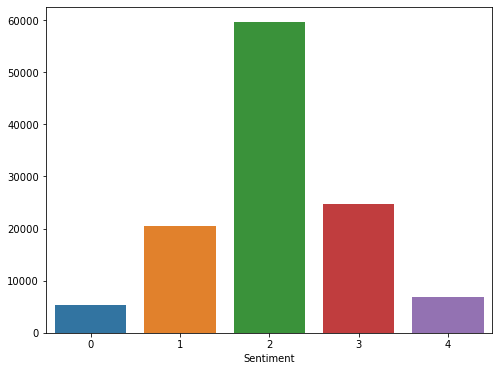

In [52]:
#check unique sentiment label
df['Sentiment'].unique()

#array([3, 1, 2, 0, 4], dtype=int64)
#0 - most negative
#1 - somewhat negative
#2 - neutral
#3 - somewhat postive
#4 - most positive

#check distribution of sentiment
dist = df.groupby(["Sentiment"]).size()

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(dist.keys(), dist.values);

In [53]:
#use this to determine class for each sentiment
#since neutral tone is the most occured one, use it as the nominator i.e. Wi = ni / n2

weight = {0: dist[2]/dist[0],
         1: dist[2]/dist[1],
         2: dist[2]/dist[2],
         3: dist[2]/dist[3],
         4: dist[2]/dist[4]}
weight

{0: 11.346849419379403,
 1: 2.8986529202937317,
 2: 1.0,
 3: 2.405561385099685,
 4: 8.706543967280163}

In [54]:
#dictionary for stop words
stop_words = stopwords.words('english')

#dictionary of lematising words
lemmatizer = WordNetLemmatizer()

#dictionary of stemming words
porter = PorterStemmer()

In [55]:
#Preprocessing words
def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    
    # Remove non-ASCII characters 
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    #get only letters
    text = re.sub("[^a-zA-Z]"," ",text)
    
    #lower case and split
    text = text.lower().split()
    
    #lemmatising
    text = set([lemmatizer.lemmatize(str(x)) for x in text]) #lemmatizing

    #remove stop words
    stops = set(stopwords.words("english")) #faster to search through a set than a list
    
    text = [w for w in text if not w in stops]
    
    #steming words
    text = [porter.stem(w) for w in text]
    
    #join words
    text = " ".join(text)
    return text

preprocessor("Hi there, I am loving this, like with 234a& lot of love. He loves it too@~@>: @A:>S")

'hi like love love lot'

In [56]:
# Split a text into list of words
def tokenizer(text):
    return text.split()

In [57]:
#determine X and y accordingly 
#X = df['Phrase']
#y = df['Sentiment']

X = df['Phrase']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)

In [76]:
#vertorise data with features
tfidf = TfidfVectorizer(input='content',
                        encoding='utf-8', 
                        decode_error='strict',
                        strip_accents = None,
                        lowercase = True,
                        preprocessor=preprocessor,
                        tokenizer=tokenizer,
                        analyzer = 'word',
                        stop_words=None,
                        dtype=np.float64,
                        binary = False)

logistic_regression = LogisticRegression(penalty='l2', 
                                         dual=False, 
                                         tol=0.000001, 
                                         C=1.0, 
                                         fit_intercept=True, 
                                         intercept_scaling=1, 
                                         class_weight=None,#weight, 
                                         random_state=102, 
                                         solver='lbfgs', 
                                         max_iter=5000000, 
                                         multi_class='multinomial', 
                                         verbose=0, 
                                         warm_start=True, 
                                         n_jobs=None, 
                                         l1_ratio=None)

# A pipeline is what chains several steps together, once the initial exploration is done. 
# For example, some codes are meant to transform features — normalise numericals, or turn text into vectors, 
# or fill up missing data, they are transformers; other codes are meant to predict variables by fitting an algorithm,
# they are estimators. Pipeline chains all these together which can then be applied to training data
clf = Pipeline([('vect', tfidf),
                ('clf', logistic_regression)])

In [77]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(preprocessor=<function preprocessor at 0x000001E134498AF8>,
                                 tokenizer=<function tokenizer at 0x000001E134498B88>)),
                ('clf',
                 LogisticRegression(max_iter=5000000, multi_class='multinomial',
                                    random_state=102, tol=1e-06,
                                    warm_start=True))])

In [78]:
#Test prediction
predictions = clf.predict(X_test)

In [70]:
#Evaluate
print('accuracy:',accuracy_score(y_test,predictions))
print('confusion matrix:\n',confusion_matrix(y_test,predictions))
print('classification report:\n',classification_report(y_test,predictions))

#balanced weight, iterations: 100k --> same as 1mil iterations
# accuracy: 0.6268529198171643 
# confusion matrix:
#  [[  166   497   302    42     2]
#  [  111  1436  2322   211     6]
#  [   26   642 10444   823    30]
#  [    5   123  2378  2314   162]
#  [    0    16   266   771   314]]
# classification report:
#                precision    recall  f1-score   support

#            0       0.54      0.16      0.25      1009
#            1       0.53      0.35      0.42      4086
#            2       0.66      0.87      0.75     11965
#            3       0.56      0.46      0.51      4982
#            4       0.61      0.23      0.33      1367

#     accuracy                           0.63     23409
#    macro avg       0.58      0.42      0.45     23409
# weighted avg       0.61      0.63      0.60     23409

accuracy: 0.5702934768678714
confusion matrix:
 [[ 625  300   35   35   14]
 [ 978 2004  762  258   84]
 [ 512 1835 7524 1678  416]
 [ 105  295 1064 2283 1235]
 [  16   20   40  377  914]]
classification report:
               precision    recall  f1-score   support

           0       0.28      0.62      0.39      1009
           1       0.45      0.49      0.47      4086
           2       0.80      0.63      0.70     11965
           3       0.49      0.46      0.47      4982
           4       0.34      0.67      0.45      1367

    accuracy                           0.57     23409
   macro avg       0.47      0.57      0.50     23409
weighted avg       0.62      0.57      0.59     23409



Text(0.5, 15.0, 'Predicted label')

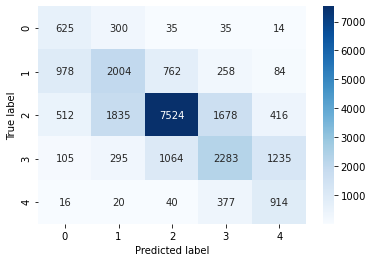

In [71]:
cm = confusion_matrix(y_test, predictions)
# view with a heatmap
sns.heatmap(cm, annot=True,fmt='g', cmap='Blues', xticklabels=['0', '1','2','3','4'], yticklabels=['0', '1','2','3','4'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [72]:
#dump into an pickle file to read and run later
pickle.dump(clf, open('review_logistic_regression.pkl', 'wb'))

In [73]:
#read pickle file model
with open('review_logistic_regression.pkl', 'rb') as model:
    reload_model = pickle.load(model)
    

In [74]:
#read test.csv file and make prediction
df_test_unlabel = pd.read_csv('test.csv')
X_test_unlabel = df_test['Phrase']

preds = reload_model.predict(X_test)


In [75]:
#save to submission.csv file
df_test['Sentiment'] = preds
df_test.to_csv('./submission.csv', index=False)

ValueError: Length of values (23409) does not match length of index (39015)